In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations



In [3]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [5]:
def distance_from_cc(lat, long):
    return haversine_distance(lat, long, 47.606, -122.332)

In [6]:
y = df.price
X = df.drop(labels=['price'], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 5)

In [8]:
eda_df = pd.concat([pd.DataFrame(y_train), X_train], axis=1).drop('id', axis=1).reset_index(drop=True)

In [10]:
baseline_model = sm.formula.ols(formula='price ~ sqft_living', data = eda_df).fit()

baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.668e+04
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:20:54   Log-Likelihood:            -2.4012e+05
No. Observations:               17277   AIC:                         4.803e+05
Df Residuals:                   17275   BIC:                         4.803e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.574e+04   4958.793     -9.225      0.000   -5.55e+04    -3.6e+04
sqft_living   282.1408      2.184    129.165      0.000     277.859     286.422
==============================================================================
Omnibus:                    12090.176   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           474100.489
Skew:                           2.885   Prob(JB):                         0.00
Kurtosis:                      28.006   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
eda_df['distance_from_seattle'] = distance_from_cc(eda_df['lat'], eda_df['long'])
eda_df['sqft_divide_distance'] = eda_df['sqft_living'] / eda_df['distance_from_seattle']
eda_df['logprice'] = np.log(eda_df['price'])
eda_df['logsqft_living'] = np.log(eda_df['sqft_living'])
eda_df['logged_distance_from_seattle'] = np.log(eda_df['distance_from_seattle'])
eda_df['logged_sqft_divide_distance'] = np.log(eda_df['sqft_divide_distance'])

In [38]:
eda_df

,price,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,lat,long,sqft_living15,sqft_lot15,distance_from_seattle,sqft_divide_distance,logprice,logsqft_living,logged_distance_from_seattle,logged_sqft_divde_distance
0,405000.0,4/3/2015,4,2.50,2620,9359,2.0,0.0,0.0,3,...,47.4380,-122.152,2580,7433,23.06,113.616652,12.911642,7.870930,3.138100,4.732830
1,631750.0,8/18/2014,3,1.75,2360,4063,1.0,0.0,0.0,5,...,47.6902,-122.382,1660,4063,10.08,234.126984,13.356249,7.766417,2.310553,5.455864
2,452500.0,10/9/2014,3,2.50,2240,7791,2.0,0.0,0.0,3,...,47.5361,-121.880,2480,5018,34.79,64.386318,13.022543,7.714231,3.549330,4.164901
3,4670000.0,6/17/2014,5,6.75,9640,13068,1.0,1.0,4.0,3,...,47.5570,-122.210,3270,10454,10.65,905.164319,15.356670,9.173676,2.365560,6.808116
4,709000.0,2/24/2015,3,2.75,2780,7200,1.5,0.0,0.0,4,...,47.5632,-122.270,1700,7200,6.65,418.045113,13.471611,7.930206,1.894617,6.035589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17272,288000.0,7/31/2014,3,1.75,1660,10440,1.0,0.0,0.0,3,...,47.4448,-121.770,1240,10380,45.85,36.205016,12.570716,7.414573,3.825375,3.589198
17273,525000.0,3/13/2015,3,2.50,2200,4544,2.0,0.0,0.0,3,...,47.5319,-121.867,2400,5431,35.85,61.366806,13.171154,7.696213,3.579344,4.116869
17274,290000.0,7/24/2014,2,1.50,770,850,2.0,0.0,0.0,3,...,47.5644,-122.388,1350,915,6.25,123.200000,12.577636,6.646391,1.832581,4.813809
17275,465000.0,3/27/2015,5,1.75,2000,10246,1.0,0.0,2.0,3,...,47.5084,-122.246,2340,9030,12.63,158.353127,13.049793,7.600902,2.536075,5.064828


In [45]:
new_model = sm.formula.ols(formula='logprice ~ logged_sqft_divide_distance + grade + logsqft_living + sqft_living15 + distance_from_seattle', data = eda_df).fit()

new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     9118.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:50:05   Log-Likelihood:                -2247.4
No. Observations:               17277   AIC:                             4507.
Df Residuals:                   17271   BIC:                             4553.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       9.2655      0.052    178.219      0.000       9.164       9.367
logged_sqft_divide_distance     0.2090      0.009     23.782      0.000       0.192       0.226
grade                           0.1316      0.003     45.003      0.000       0.126       0.137
logsqft_living                  0.2080      0.012     17.505      0.000       0.185       0.231
sqft_living15                   0.0002   4.97e-06     36.108      0.000       0.000       0.000
distance_from_seattle          -0.0087      0.001    -16.052      0.000      -0.010      -0.008
==============================================================================
Omnibus:                      178.470   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.931
Skew:                           0.029   Prob(JB):                     2.73e-66
Kurtosis:                       3.645   Cond. No.                     5.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
city = eda_df[eda_df['distance_from_seattle'] <= 12]
suburb = eda_df[(eda_df['distance_from_seattle'] > 12) & (eda_df['distance_from_seattle'] <= 25)]
rural = eda_df[(eda_df['distance_from_seattle'] > 25)]

In [18]:
regression1 = LinearRegression()
regression2 = LinearRegression()
regression3 = LinearRegression()

sqft_1 = city['sqft_living'].values.reshape(-1, 1)
sqft_2 = suburb['sqft_living'].values.reshape(-1, 1)
sqft_3 = rural['sqft_living'].values.reshape(-1, 1)

regression1.fit(sqft_1, city['price'])
regression2.fit(sqft_2, suburb['price'])
regression3.fit(sqft_3, rural['price'])

pred_1 = regression1.predict(sqft_1)
pred_2 = regression2.predict(sqft_2)
pred_3 = regression3.predict(sqft_3)

print(regression1.coef_)
print(regression2.coef_)
print(regression3.coef_)

[413.70954497]
[254.28729415]
[191.44884962]


In [21]:
import seaborn as sns

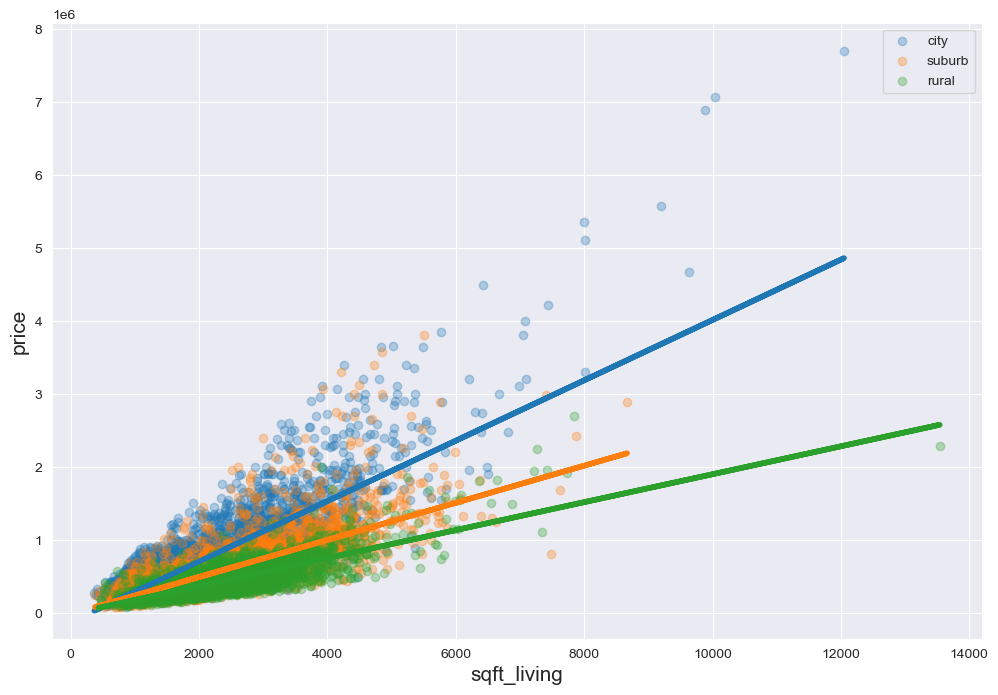

In [55]:

fig = plt.figure(figsize = (12, 8))

sns.set_style('darkgrid')

plt.scatter(sqft_1, city['price'],  alpha=0.3, label = 'city')
plt.scatter(sqft_2, suburb['price'], alpha=0.3, label = 'suburb')
plt.scatter(sqft_3, rural['price'],  alpha=0.3, label = 'rural')

plt.plot(sqft_1, pred_1, linewidth=4)
plt.plot(sqft_2, pred_2, linewidth=4)
plt.plot(sqft_3, pred_3, linewidth=4)


plt.ylabel('price', fontsize = 15)
plt.xlabel('sqft_living', fontsize = 15)
plt.legend();